## Part 1

In [1]:
import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# DATA LOADING PART
import json, gzip
from pathlib import Path

# Function to iterate over JSON objects in a file (handles both JSON Lines and JSON array formats). 
#This code was AI-assisted

def iter_json_objects(path):
    opener = gzip.open if str(path).endswith('.gz') else open
    with opener(path, 'rt', encoding='utf-8') as f:
        first = f.read(1)
        f.seek(0)
        if first == '[':
            try:
                import ijson
                for obj in ijson.items(f, 'item'):
                    yield obj
            except ImportError:
                data = json.load(f)
                for obj in data:
                    yield obj
        else:
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)

# Here we build a path to the dataset, which is two levels up from this notebook
NOTEBOOK_DIR = Path().resolve()
DATA_PATH = NOTEBOOK_DIR.parents[1] / "data" / "fashion_products_dataset.json"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please make sure 'fashion_products_dataset.json' is placed in the 'data/' folder at the repo root."
    )

print("Dataset path:", DATA_PATH)

# Load records
records = list(iter_json_objects(DATA_PATH))
print(f"Loaded {len(records)} records successfully")



Dataset path: C:\Users\alber\Documents\GitHub\irwa-search-engine-g_019\data\fashion_products_dataset.json
Loaded 28080 records successfully


In [3]:


#DATA PREPARATION PART

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

#Here we convert strings into numbers safely
def to_number(x):
    if x is None:
        return np.nan
    # Already numeric
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(",", "").strip().lower()
    # Handle '69% off'
    if "% off" in s:
        s = s.split("%")[0]
    # Handle booleans like "true"/"false"
    if s in ["true", "false"]:
        return 1.0 if s == "true" else 0.0
    try:
        return float(s)
    except ValueError:
        return np.nan


# With this we convert the list of product details (a list of dictionaries) into a single text string.
def details_to_text(details):
    """Convert list of detail dicts into a single readable string."""
    if not details:
        return ""
    out = []
    for d in details:
        if isinstance(d, dict):
            for key, val in d.items():
                out.append(f"{key} {val}")
    return " ".join(out)


# Here we process each product record to extract and clean relevant fields.
def process_product(prod):

    # 1) concatenating title, description, product_details
    title = prod.get("title", "")
    desc = prod.get("description", "")
    dets = details_to_text(prod.get("product_details"))
    full_text = f"{title} {desc} {dets}"

    # 2) tokenize, lowercase, remove stopwords, stem
    tokens = word_tokenize(full_text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    clean_text = " ".join(tokens)

    # 3) returning processed row
    return {
        "pid": prod.get("pid", ""),
        "title": title,
        "description": desc,
        "brand": prod.get("brand", ""),
        "category": prod.get("category", ""),
        "sub_category": prod.get("sub_category", ""),
        "product_details": prod.get("product_details", []),
        "seller": prod.get("seller", ""),
        "out_of_stock": to_number(prod.get("out_of_stock")),
        "selling_price": to_number(prod.get("selling_price")),
        "discount": to_number(prod.get("discount")),
        "actual_price": to_number(prod.get("actual_price")),
        "average_rating": to_number(prod.get("average_rating")),
        "url": prod.get("url", ""),
        "tokens": clean_text
    }



In [4]:
# Process -> list of dicts
processed_data = [process_product(rec) for rec in iter_json_objects(DATA_PATH)]

# DataFrame in one go
products_df = pd.DataFrame(processed_data)

# Use product ID as index
products_df.set_index("pid", inplace=True)

# Preview like they did
products_df.head(4)


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url,tokens
pid,,,,,,,,,,,,,,
TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,0.0,921.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...
TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,0.0,499.0,66.0,1499.0,3.9,https://www.flipkart.com/yorker-solid-men-blue...,solid men blue track pant yorker trackpant mad...
TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,0.0,931.0,68.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid men multicolor track pant yorker trackpa...
TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,0.0,911.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...


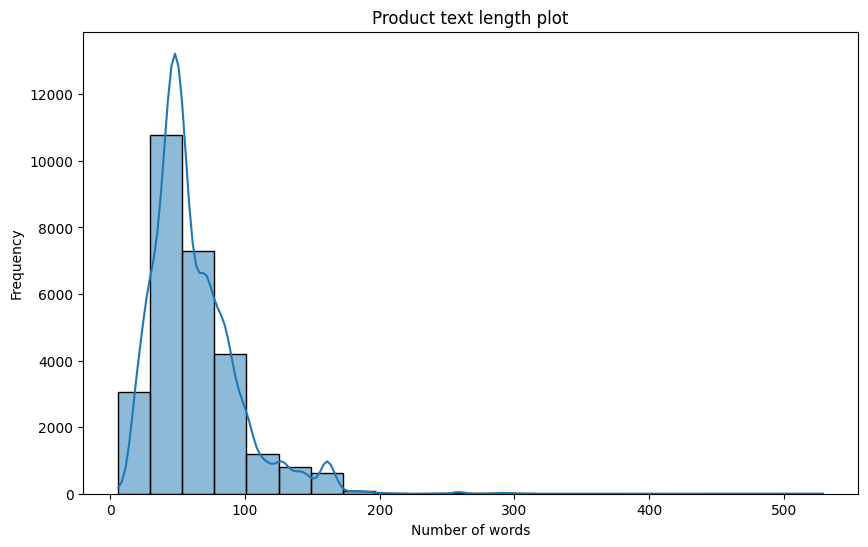

In [5]:
# Product text length plot

# Aux column for the length of each
vocab_df = products_df.copy()
vocab_df['Wordcount'] = products_df['tokens'].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)

plt.title('Product text length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()


In [6]:
# Getting info about our vocabulary (products)

# All product tokens in a single list of words
whole_content = products_df['tokens'].fillna('').str.split().explode().tolist()

# Counting appearances
word_counts = Counter(whole_content)

# Converting to dict
vocab_dict = dict(word_counts)
print('Product vocabulary size is', len(vocab_dict))

# Sorting dictionary items to get the top 5 appearing words
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
    print(item)


Product vocabulary size is 15877

The top 5 most appearing words are:
('fabric', 57213)
('neck', 56553)
('sleev', 50876)
('fit', 39523)
('type', 38701)


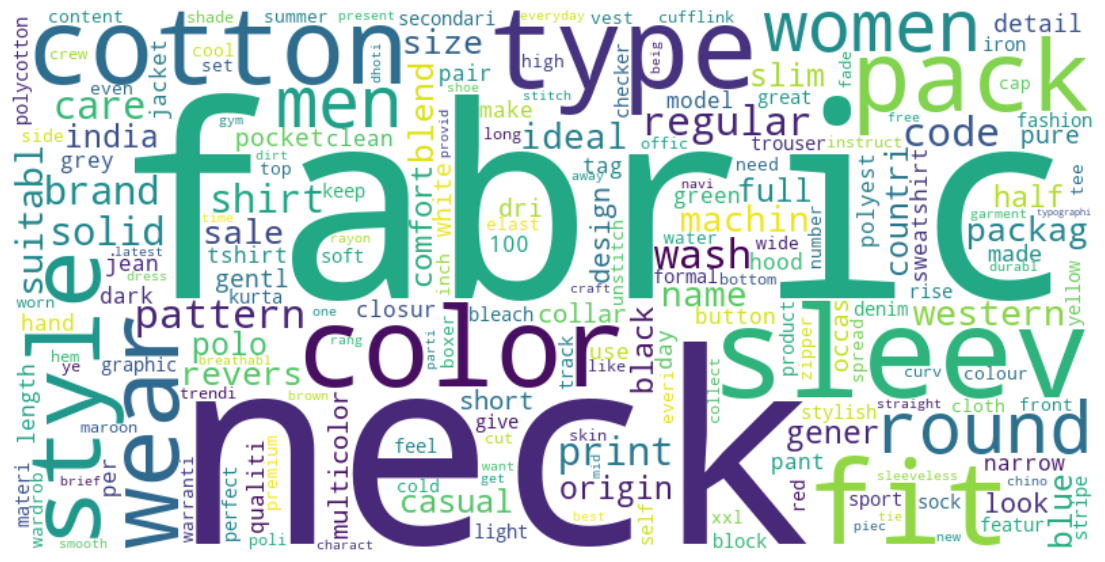

In [7]:
# Generating a word cloud for product tokens
# Create a WordCloud object with specified dimensions and background color
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)

# Display the generated word cloud
plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# Creating a new dataframe sorted by highest rating
rated_df = products_df.copy()
# Sort the DataFrame by 'average_rating' in descending order
rated_sorted = rated_df.sort_values(by='average_rating', ascending=False)

print('The following are the Top 5 Highest-Rated Products:')
# Display the top 5 rows of the sorted DataFrame, resetting the index and dropping specified columns
rated_sorted.reset_index().drop(columns=['pid','url'], errors='ignore').head(5)

The following are the Top 5 Highest-Rated Products:


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,tokens
0,Men Brief (Pack of 5),Regular use & fit,COL,Clothing and Accessories,Innerwear and Swimwear,"[{'Color': 'Multicolor'}, {'Fabric': 'Cotton J...",SkipperInd,0.0,385.0,50.0,770.0,5.0,men brief pack regular use fit color multicolo...
1,VIP Women Vest (Pack of 8),All day comfort and support from work to play ...,,Clothing and Accessories,Innerwear and Swimwear,"[{'Neck': 'Round Neck'}, {'Pattern': 'Solid'},...",,1.0,1108.0,7.0,1196.0,5.0,vip women vest pack day comfort support work p...
2,Graphic Print Women Round Neck White T-Shirt,,TEE BUD,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",T-SHIRT EXPRESS,0.0,349.0,61.0,899.0,5.0,graphic print women round neck white type roun...
3,Men Brief (Pack of 5),100 cm,VIKING.INE,Clothing and Accessories,Innerwear and Swimwear,"[{'Color': 'Multicolor'}, {'Fabric': 'Cotton B...",,1.0,699.0,NaN,NaN,5.0,men brief pack 100 color multicolor fabric cot...
4,Men Slim Fit Printed Spread Collar Casual Shirt,,True Bl,Clothing and Accessories,Topwear,"[{'Pack of': '1'}, {'Style Code': '20319816-Be...",KAPSONSRETAILPVTLTD,0.0,1119.0,60.0,2799.0,5.0,men slim fit print spread collar casual shirt ...


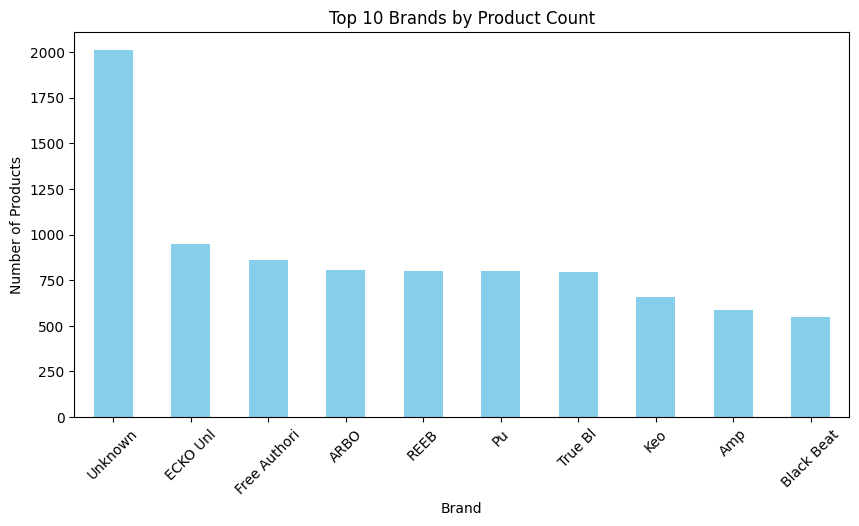

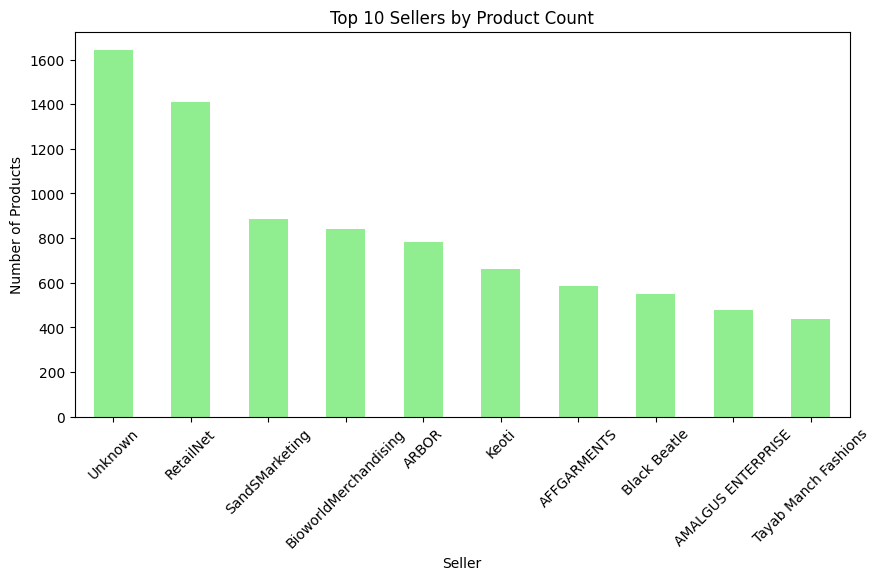

In [9]:
# Fill missing values in 'brand' with 'Unknown' and replace empty strings with 'Unknown'
products_df['brand'] = products_df['brand'].fillna('Unknown')
products_df['brand'] = products_df['brand'].replace('', 'Unknown')
# Get the top 10 most frequent brands
top_brands = products_df['brand'].value_counts().head(10)

# Plot the top 10 brands
plt.figure(figsize=(10,5))
top_brands.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

# Fill missing values in 'seller' with 'Unknown' and replace empty strings with 'Unknown'
products_df['seller'] = products_df['seller'].fillna('Unknown')
products_df['seller'] = products_df['seller'].replace('', 'Unknown')
# Get the top 10 most frequent sellers
top_sellers = products_df['seller'].value_counts().head(10)

# Plot the top 10 sellers
plt.figure(figsize=(10,5))
top_sellers.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Seller')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

## Part 2 — Indexing & Evaluation

In [10]:
# ==== CONFIG: choose the text column you built in Part 1 ====
TEXT_COL = "tokens_plus" if "tokens_plus" in products_df.columns else "tokens"

# ==== Build vocabulary and postings with term frequencies ====
from collections import defaultdict, Counter
import math

docs = products_df[TEXT_COL].fillna("")
doc_ids = products_df.index.astype(str).tolist()  # pid as string

vocab = {}                  # term -> term_id
postings = defaultdict(list) # term -> list of (doc_id, tf)
df = Counter()              # document frequency per term

for pid, text in zip(doc_ids, docs):
    terms = text.split()
    if not terms:
        continue
    tf = Counter(terms)
    for t, f in tf.items():
        if t not in vocab:
            vocab[t] = len(vocab)
        df[t] += 1
        postings[t].append((pid, f))

N = len(doc_ids)
idf = {t: math.log((N + 1) / (df[t] + 1)) + 1.0 for t in df}  # smooth IDF

# ==== Precompute document TF-IDF norms for cosine ====
doc_norm = defaultdict(float)
for t, plist in postings.items():
    w_idf = idf[t]
    for pid, f in plist:
        w = (1 + math.log(f)) * w_idf  # log-tf * idf
        doc_norm[pid] += w * w
for pid in list(doc_norm.keys()):
    doc_norm[pid] = math.sqrt(doc_norm[pid])

# ==== Query processing (reuse your Part 1 choices) ====
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_query(q):
    toks = word_tokenize(q)
    toks = [t.lower() for t in toks if t.isalnum()]
    toks = [stemmer.stem(t) for t in toks if t not in stop_words and len(t) > 2]
    return toks

# ==== Conjunctive retrieval + TF-IDF cosine ranking ====
def search_and_rank(query, top_k=20):
    q_terms = preprocess_query(query)
    if not q_terms:
        return []

    # AND filter (only docs containing ALL terms), as required in the brief
    # Start from postings of the rarest term to keep it fast
    term_lists = []
    for t in q_terms:
        if t not in postings:
            return []  # no docs contain this term
        term_lists.append(set(pid for pid, _ in postings[t]))
    cand = set.intersection(*term_lists) if term_lists else set()

    if not cand:
        return []

    # Query weights
    q_tf = Counter(q_terms)
    q_weights = {}
    q_norm = 0.0
    for t, f in q_tf.items():
        w = (1 + math.log(f)) * idf.get(t, 0.0)
        q_weights[t] = w
        q_norm += w*w
    q_norm = math.sqrt(q_norm) if q_norm > 0 else 1.0

    # Score candidates
    scores = defaultdict(float)
    for t, wq in q_weights.items():
        for pid, f in postings.get(t, []):
            if pid not in cand:
                continue
            wd = (1 + math.log(f)) * idf.get(t, 0.0)
            scores[pid] += wq * wd

    # Normalize (cosine)
    ranked = []
    for pid, s in scores.items():
        dnorm = doc_norm.get(pid, 1.0)
        ranked.append((pid, s / (dnorm * q_norm if dnorm else 1.0)))

    ranked.sort(key=lambda x: x[1], reverse=True)
    # return small dataframe for convenience
    out = products_df.loc[[pid for pid, _ in ranked[:top_k]], ["title","brand","category","url"]].copy()
    out.insert(0, "pid", [pid for pid,_ in ranked[:top_k]])
    out["score"] = [score for _, score in ranked[:top_k]]
    return out

# quick smoke test:
display(search_and_rank("women full sleeve sweatshirt cotton", top_k=10))


,pid,title,brand,category,url,score
pid,,,,,,
SWSF9W4TCKGPSSZZ,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.631933
SWSFYTYMNTBNARUN,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...,0.627816
SWSFYFFFJZN6P6ZW,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...,0.622971
SWSF9W3ZHHJFQFJF,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.610852
SWSFZAUYZFAGEPKK,SWSFZAUYZFAGEPKK,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories,https://www.flipkart.com/black-snow-full-sleev...,0.602448
SWSFVZRFS7GHGKSF,SWSFVZRFS7GHGKSF,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories,https://www.flipkart.com/relief-zone-full-slee...,0.601032
SWSF9W4TBFMF3GZA,SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.600254
SWSF9W4HABG6BBY4,SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.594443
SWSF9W4TTB2M9ZXT,SWSF9W4TTB2M9ZXT,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.591259


In [11]:
# naive, but effective: pick frequent tokens & compose short realistic queries
from collections import Counter
top_terms = Counter(" ".join(products_df[TEXT_COL].fillna("")).split()).most_common(50)
cands = [t for t,_ in top_terms if t not in {"women","men","size","color"}]  # drop too-generic words if present

test_queries = [
    "women cotton sweatshirt",
    "men slim fit jeans blue",
    "hoodi fleece winter",
    "women black dress",
    "sport shoe breathabl"
]
test_queries  # feel free to edit to your taste


['women cotton sweatshirt',
 'men slim fit jeans blue',
 'hoodi fleece winter',
 'women black dress',
 'sport shoe breathabl']

In [12]:
for q in test_queries:
    print(f"\nQuery: {q}")
    display(search_and_rank(q, top_k=5))



Query: women cotton sweatshirt


,pid,title,brand,category,url,score
pid,,,,,,
SWSFYFFFJZN6P6ZW,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...,0.536818
SWSFVZRFS7GHGKSF,SWSFVZRFS7GHGKSF,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories,https://www.flipkart.com/relief-zone-full-slee...,0.517438
SWSF9W4TCKGPSSZZ,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.516891
SWSFYTYMNTBNARUN,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...,0.513524
SWSF9W3ZHHJFQFJF,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.499648



Query: men slim fit jeans blue


,pid,title,brand,category,url,score
pid,,,,,,
JEAEVJGUSXRNSHRY,JEAEVJGUSXRNSHRY,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories,https://www.flipkart.com/absolute-slim-men-dar...,0.421468
JEAENP3UUGESZVH9,JEAENP3UUGESZVH9,Slim Men Light Blue Jeans,Uber Urb,Clothing and Accessories,https://www.flipkart.com/uber-urban-slim-men-l...,0.419477
JEAFUZXPUWKSKGVD,JEAFUZXPUWKSKGVD,Tapered Fit Men Blue Jeans,ECKO Unl,Clothing and Accessories,https://www.flipkart.com/ecko-unltd-tapered-fi...,0.398755
JEAFUZXRDZWSYWGG,JEAFUZXRDZWSYWGG,Tapered Fit Men Blue Jeans,ECKO Unl,Clothing and Accessories,https://www.flipkart.com/ecko-unltd-tapered-fi...,0.398755
JEAFUZXT6BYHVNF2,JEAFUZXT6BYHVNF2,Tapered Fit Men Blue Jeans,ECKO Unl,Clothing and Accessories,https://www.flipkart.com/ecko-unltd-tapered-fi...,0.398755



Query: hoodi fleece winter


,pid,title,brand,category,url,score
pid,,,,,,
SWSFW6BQ74JCVHHH,SWSFW6BQ74JCVHHH,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories,https://www.flipkart.com/jack-hardy-full-sleev...,0.399223
SWSFWG9BUDKAPD55,SWSFWG9BUDKAPD55,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories,https://www.flipkart.com/jack-hardy-full-sleev...,0.399223
SWSFW6BQDDJHZEJV,SWSFW6BQDDJHZEJV,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories,https://www.flipkart.com/jack-hardy-full-sleev...,0.399223
SWSFWG9BJ5U5BRBU,SWSFWG9BJ5U5BRBU,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories,https://www.flipkart.com/jack-hardy-full-sleev...,0.399223
SWSFWG9BXWWDZVCA,SWSFWG9BXWWDZVCA,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories,https://www.flipkart.com/jack-hardy-full-sleev...,0.399223



Query: women black dress


,pid,title,brand,category,url,score
pid,,,,,,
KTAFPHHVKZZ5GEHY,KTAFPHHVKZZ5GEHY,Women Embroidered Cotton Lycra Blend Ethnic Dr...,saltla,Clothing and Accessories,https://www.flipkart.com/saltlake-men-embroide...,0.414616
KTAFVPFKWGDFQGEE,KTAFVPFKWGDFQGEE,Women Solid Khadi Silk Ethnic Dress (Black),SATDEVANGIKHADIBHAND,Clothing and Accessories,https://www.flipkart.com/satdevangikhadibhanda...,0.305576
KTAFVPFKU9JYRNGZ,KTAFVPFKU9JYRNGZ,Women Solid Khadi Silk Ethnic Dress (Black),SATDEVANGIKHADIBHAND,Clothing and Accessories,https://www.flipkart.com/satdevangikhadibhanda...,0.304096
KTAFVPFKHZW4YVZS,KTAFVPFKHZW4YVZS,Women Solid Khadi Silk Ethnic Dress (Black),SATDEVANGIKHADIBHAND,Clothing and Accessories,https://www.flipkart.com/satdevangikhadibhanda...,0.303353
KTAFVPFKACERTGVH,KTAFVPFKACERTGVH,Women Solid Khadi Silk Ethnic Dress (Black),SATDEVANGIKHADIBHAND,Clothing and Accessories,https://www.flipkart.com/satdevangikhadibhanda...,0.291783



Query: sport shoe breathabl


,pid,title,brand,category,url,score
pid,,,,,,
SOCFPDPFXUFZKHHB,SOCFPDPFXUFZKHHB,Original Cotton Flat Knit Women Ankle Length ...,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-original-cotto...,0.118398
SOCFPDP2MX7RPJZP,SOCFPDP2MX7RPJZP,Original Cotton Flat Knit Women Ankle Length ...,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-original-cotto...,0.117640
SOCFPDPFCTCG4GBB,SOCFPDPFCTCG4GBB,Original Cotton Flat Knit Women Solid Ankle Le...,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-original-cotto...,0.117559
SOCFPDZHSMMY8PZQ,SOCFPDZHSMMY8PZQ,Original Cotton Flat Knit Women Striped Ankle ...,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-original-cotto...,0.116536
SOCFPDPFXQCQFA8C,SOCFPDPFXQCQFA8C,Original Cotton Flat Knit Men Solid Low Cut (...,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-original-cotto...,0.116523


In [13]:
# ---- Metrics ----
import numpy as np

def precision_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / max(1, len(pred))

def recall_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    rel_total = sum(y_true.values())
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / max(1, rel_total)

def ap_at_k(y_true, y_pred, k=10):
    ap, hits = 0.0, 0
    for i, pid in enumerate(y_pred[:k], start=1):
        if y_true.get(pid, 0):
            hits += 1
            ap += hits / i
    rel_total = sum(y_true.values())
    return ap / max(1, min(rel_total, k))

def f1_at_k(y_true, y_pred, k=10):
    p = precision_at_k(y_true, y_pred, k)
    r = recall_at_k(y_true, y_pred, k)
    return 2*p*r / (p + r) if (p+r) > 0 else 0.0

def map_score(list_of_labeldicts, list_of_rankings, k=10):
    aps = [ap_at_k(y_true, y_pred, k) for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings)]
    return float(np.mean(aps)) if aps else 0.0

def mrr(list_of_labeldicts, list_of_rankings, k=10):
    rr = []
    for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings):
        rank = None
        for i, pid in enumerate(y_pred[:k], start=1):
            if y_true.get(pid, 0):
                rank = i; break
        rr.append(1.0/rank if rank else 0.0)
    return float(np.mean(rr)) if rr else 0.0

def ndcg_at_k(y_true, y_pred, k=10):
    # binary gains from labels
    gains = [y_true.get(pid, 0) for pid in y_pred[:k]]
    dcg = sum(g / math.log2(i+2) for i, g in enumerate(gains))
    # ideal DCG
    ideal_gains = sorted(y_true.values(), reverse=True)[:k]
    idcg = sum(g / math.log2(i+2) for i, g in enumerate(ideal_gains))
    return dcg / idcg if idcg > 0 else 0.0


In [14]:
# Load labels: columns expected: query_id, pid, label
val = pd.read_csv("../../data/validation_labels.csv")
val["pid"] = val["pid"].astype(str)

# mapping from query text given in the brief
predef_queries = {
    1: "women full sleeve sweatshirt cotton",
    2: "men slim jeans blue",
}

K = 10  # you can change K if your instructor specifies another cutoff

metric_table = []  # rows: [query_id, P@K, R@K, AP@K, F1@K, NDCG@K] + MAP/MRR computed across queries

all_labeldicts, all_rankings = [], []

for qid, qtext in predef_queries.items():
    sub = val[val["query_id"] == qid].copy()
    # label dict for this query: pid -> 0/1
    labeldict = dict(zip(sub["pid"], sub["labels"]))
    # rank only those candidate pids (so metrics compare apples-to-apples with provided judgments)
    ranked_df = search_and_rank(qtext, top_k=len(sub))  # our full ranking
    ranked_pids = [pid for pid in ranked_df["pid"].tolist() if pid in labeldict]
    # append any remaining judged docs (that our system didn't retrieve) to the tail to make a full ordering
    tail = [pid for pid in sub["pid"].tolist() if pid not in set(ranked_pids)]
    final_order = ranked_pids + tail

    P = precision_at_k(labeldict, final_order, K)
    R = recall_at_k(labeldict, final_order, K)
    AP = ap_at_k(labeldict, final_order, K)
    F1 = f1_at_k(labeldict, final_order, K)
    N = ndcg_at_k(labeldict, final_order, K)

    metric_table.append([qid, P, R, AP, F1, N])
    all_labeldicts.append(labeldict)
    all_rankings.append(final_order)

MAP = map_score(all_labeldicts, all_rankings, K)
MRR = mrr(all_labeldicts, all_rankings, K)

# ----- PRINT **NUMBERS ONLY** AS REQUESTED -----
# (rounded to three decimals, no extra commentary)
for row in metric_table:
    qid, P, R, AP, F1, N = row
    print(f"{qid} {P:.3f} {R:.3f} {AP:.3f} {F1:.3f} {N:.3f}")
print(f"MAP {MAP:.3f}")
print(f"MRR {MRR:.3f}")


1 0.700 0.538 0.508 0.609 0.703
2 0.600 0.600 0.473 0.600 0.665
MAP 0.490
MRR 1.000


In [15]:
# Helper to finalize labels, compute metrics, and print nicely
def evaluate_labeled_query(results_df, rel_idx, k=10):
    ranking, y_true = finalize_labels(results_df, rel_idx)
    P  = precision_at_k(y_true, ranking, k)
    R  = recall_at_k(y_true, ranking, k)
    AP = ap_at_k(y_true, ranking, k)
    F1 = f1_at_k(y_true, ranking, k)
    N  = ndcg_at_k(y_true, ranking, k)
    print(f"P@{k}={P:.3f} R@{k}={R:.3f} AP@{k}={AP:.3f} F1@{k}={F1:.3f} NDCG@{k}={N:.3f}")
    return ranking, y_true  # returned in case you want them


def label_query_noinput(q, top_k=30):
    df = search_and_rank(q, top_k=top_k).reset_index(drop=True)
    df.insert(0, "idx", range(len(df)))
    display(df[["idx","pid","title","brand","category"]])
    print("\nSet rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}\nThen run: ranking, y_true = finalize_labels(df, rel_idx)")
    return df

def finalize_labels(df, rel_idx):
    rel_pids = set(df.loc[list(rel_idx), "pid"])
    y_true = {pid: (pid in rel_pids) for pid in df["pid"].tolist()}
    ranking = df["pid"].tolist()
    return ranking, y_true


In [16]:
def run_one_query(q, rel_idx, k=10):
    df = label_query_noinput(q, top_k=30)
    ranking, y_true = evaluate_labeled_query(df, rel_idx, k=k)  # prints metrics
    print("Relevant PIDs:", [df.loc[i, "pid"] for i in sorted(rel_idx)])
    print("Top-10 ranking PIDs:", ranking[:10])
    return df, ranking, y_true

# Example:
df, ranking, y_true = run_one_query("men slim jeans blue", {0, 2, 5}, k=10)


,idx,pid,title,brand,category
0,0,JEAFVDRJZ5RWAFHB,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
1,1,JEAFVPFUA97ZETDB,Slim Men Blue Jeans,TimeO,Clothing and Accessories
2,2,JEAFV8WURBM7PGYT,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
3,3,JEAFSKYHZHSZZC9S,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
4,4,JEAFRAQXEKGUPNUN,Slim Men Blue Jeans,Lev,Clothing and Accessories
5,5,JEAFSKYHRVZSABPR,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
6,6,JEAFSKYHTE76YWH7,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
7,7,JEAFQF6JBUSEXHVF,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
8,8,JEAFSKYHSYMTKEJD,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
9,9,JEAEVJGUSXRNSHRY,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.300 R@10=1.000 AP@10=0.722 F1@10=0.462 NDCG@10=0.871
Relevant PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFV8WURBM7PGYT', 'JEAFSKYHRVZSABPR']
Top-10 ranking PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB', 'JEAFV8WURBM7PGYT', 'JEAFSKYHZHSZZC9S', 'JEAFRAQXEKGUPNUN', 'JEAFSKYHRVZSABPR', 'JEAFSKYHTE76YWH7', 'JEAFQF6JBUSEXHVF', 'JEAFSKYHSYMTKEJD', 'JEAEVJGUSXRNSHRY']


In [17]:
df_ws, ranking_ws, y_true_ws = run_one_query("women cotton sweatshirt", { }, k=10)

,idx,pid,title,brand,category
0,0,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories
1,1,SWSFVZRFS7GHGKSF,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories
2,2,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories
3,3,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories
4,4,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories
5,5,SWSFZAUYZFAGEPKK,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories
6,6,SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories
7,7,SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories
8,8,SWSF9W4TTB2M9ZXT,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories
9,9,SWSFVZRFCWPPZVGT,Full Sleeve Solid Men Sweatshirt,RELIEF ZO,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SWSFYFFFJZN6P6ZW', 'SWSFVZRFS7GHGKSF', 'SWSF9W4TCKGPSSZZ', 'SWSFYTYMNTBNARUN', 'SWSF9W3ZHHJFQFJF', 'SWSFZAUYZFAGEPKK', 'SWSF9W4TBFMF3GZA', 'SWSF9W4HABG6BBY4', 'SWSF9W4TTB2M9ZXT', 'SWSFVZRFCWPPZVGT']


In [18]:
df_hf, ranking_hf, y_true_hf = run_one_query("hoodie fleece winter", { }, k=10)

,idx,pid,title,brand,category
0,0,SWSFW6BQ74JCVHHH,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
1,1,SWSFWG9BUDKAPD55,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
2,2,SWSFW6BQDDJHZEJV,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
3,3,SWSFWG9BJ5U5BRBU,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
4,4,SWSFWG9BXWWDZVCA,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
5,5,SWSFWG9B7CCYYVZZ,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
6,6,SWSFWG9BTRDCWR2S,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
7,7,SWSFWG9BHYUMNSPG,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
8,8,SWSFWG9BZMUHEFHS,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories
9,9,SWSFWG9BAP5FGWG4,Full Sleeve Color Block Women Sweatshirt,JACK AND HAR,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SWSFW6BQ74JCVHHH', 'SWSFWG9BUDKAPD55', 'SWSFW6BQDDJHZEJV', 'SWSFWG9BJ5U5BRBU', 'SWSFWG9BXWWDZVCA', 'SWSFWG9B7CCYYVZZ', 'SWSFWG9BTRDCWR2S', 'SWSFWG9BHYUMNSPG', 'SWSFWG9BZMUHEFHS', 'SWSFWG9BAP5FGWG4']


In [19]:
df_fd, ranking_fd, y_true_fd = run_one_query("women black jeans", { }, k=10)

,idx,pid,title,brand,category
0,0,JEAFV9YSQKSENGH6,Slim Women Black Jeans,Reliable Ca,Clothing and Accessories
1,1,JEAFV4J5AVGVWPW8,Slim Women Black Jeans,Reliable Ca,Clothing and Accessories
2,2,JEAFWYUUQMPHCV4Y,Slim Women Black Jeans,M,Clothing and Accessories
3,3,JEAFVXGBBVYPPXXR,Slim Women Black Jeans,TimeO,Clothing and Accessories
4,4,JEAFXUE3VX5SA7AU,Tapered Fit Women Black Jeans,ECKO Unl,Clothing and Accessories
5,5,JEAFUZXTVCUJSHUM,Jogger Fit Women Black Jeans,ECKO Unl,Clothing and Accessories
6,6,JEAFUZXTNPGBMJ9F,Tapered Fit Women Black Jeans,ECKO Unl,Clothing and Accessories
7,7,JEAFSKYHWXBBYXDZ,Slim Women Black Jeans,ECKO Unl,Clothing and Accessories
8,8,JEAFXUHFDUQGBHEB,Tapered Fit Women Black Jeans,ECKO Unl,Clothing and Accessories
9,9,JEAFF3TGFMW6KMBG,Regular Women Black Jeans,M.R. FASHI,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['JEAFV9YSQKSENGH6', 'JEAFV4J5AVGVWPW8', 'JEAFWYUUQMPHCV4Y', 'JEAFVXGBBVYPPXXR', 'JEAFXUE3VX5SA7AU', 'JEAFUZXTVCUJSHUM', 'JEAFUZXTNPGBMJ9F', 'JEAFSKYHWXBBYXDZ', 'JEAFXUHFDUQGBHEB', 'JEAFF3TGFMW6KMBG']


In [20]:
df_rs, ranking_rs, y_true_rs = run_one_query("women black leggings", { }, k=10)

,idx,pid,title,brand,category
0,0,TKPFYERJQHGHSQFM,Solid Women Black Track Pants,Zack Fo,Clothing and Accessories
1,1,TKPFGZYS9CWTRMZJ,Solid Women Black Track Pants,REEB,Clothing and Accessories
2,2,TKPFK3W6VQFCYNTQ,Solid Women Black Track Pants,REEB,Clothing and Accessories
3,3,SRTFGZY9UCFAAEHM,Solid Women Black Sports Shorts,REEB,Clothing and Accessories
4,4,TKPFK3W6NVCGUTHR,Solid Women Black Track Pants,REEBOK CLASSI,Clothing and Accessories
5,5,JEAFANJNYQRETCSN,Stretchable Slim Women Black Jeans (Pack of 2),NEBRAS,Clothing and Accessories
6,6,TKPFWXYH9GQKJQXT,Solid Women Black Track Pants,Zack Fo,Clothing and Accessories
7,7,TKPFGZYSMFQGDESU,Solid Women Black Track Pants,REEBOK CLASSI,Clothing and Accessories
8,8,TKPFDHDGAYXBT3C9,Solid Women Black Track Pants,CLOTH,Clothing and Accessories
9,9,TKPFDHDH74PZGMWT,Solid Women Black Track Pants,CLOTH,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['TKPFYERJQHGHSQFM', 'TKPFGZYS9CWTRMZJ', 'TKPFK3W6VQFCYNTQ', 'SRTFGZY9UCFAAEHM', 'TKPFK3W6NVCGUTHR', 'JEAFANJNYQRETCSN', 'TKPFWXYH9GQKJQXT', 'TKPFGZYSMFQGDESU', 'TKPFDHDGAYXBT3C9', 'TKPFDHDH74PZGMWT']


In [21]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\alber\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


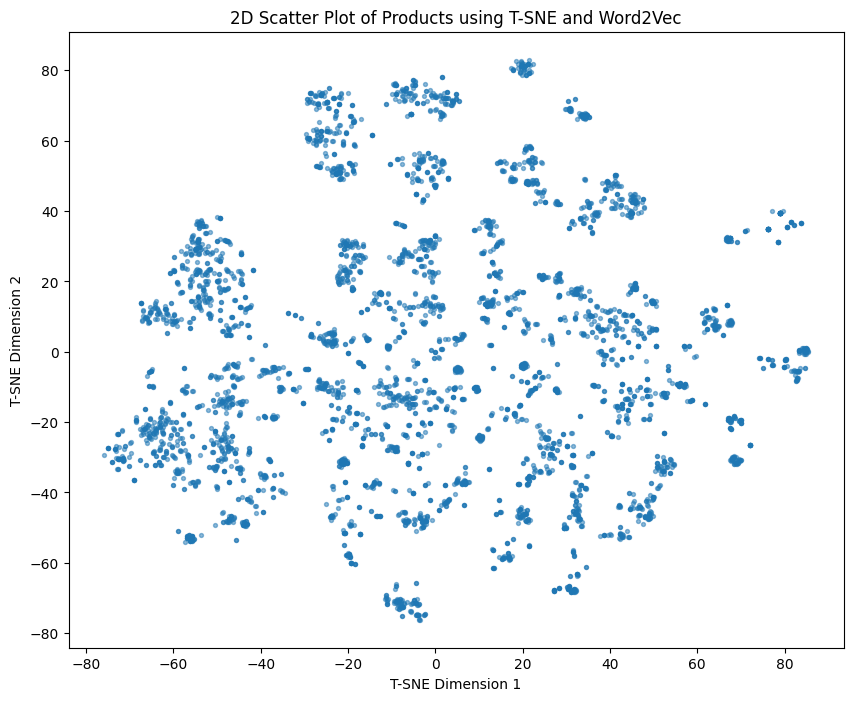

In [22]:
# 2D Scatter Plot of Products using T-SNE and Word2Vec (minimal)

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 1) Tokenize each product into a list of tokens
TOK_COL = "tokens_plus" if "tokens_plus" in products_df.columns else "tokens"
token_products = products_df.copy()
token_products["tok_list"] = token_products[TOK_COL].fillna("").apply(lambda x: x.split())

# 2) Train Word2Vec on product tokens
model = Word2Vec(
    token_products["tok_list"].tolist(),
    vector_size=100, window=5, min_count=1, workers=4, seed=0
)

# 3) Average word vectors per product
def product_to_vec(tok_list):
    vecs = [model.wv[w] for w in tok_list if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

product_vectors = np.vstack([product_to_vec(toks) for toks in token_products["tok_list"]])

# 4) T-SNE on a sample (TSNE is expensive)
rng = np.random.RandomState(0)
sample_size = min(5000, len(product_vectors))
sample_idx = rng.choice(len(product_vectors), sample_size, replace=False)
sampled_vectors = product_vectors[sample_idx]

tsne = TSNE(n_components=2, random_state=0, init="pca", learning_rate="auto")
emb2d = tsne.fit_transform(sampled_vectors)

# 5) Plot
plt.figure(figsize=(10,8))
plt.scatter(emb2d[:,0], emb2d[:,1], alpha=0.5, s=8)
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.title("2D Scatter Plot of Products using T-SNE and Word2Vec")
plt.show()
